# Imports

In [1]:
# data wrangling
import pandas as pd
import numpy as np
import re
from scipy.stats import norm
from scipy.stats import beta
from scipy.optimize import minimize

# plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# to ingore pandas warnings
import warnings

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier

# metrics
from sklearn.metrics import accuracy_score

# optimizer
from sklearn.model_selection import GridSearchCV

# k-fold cross-validation
from sklearn.model_selection import cross_val_score

# chi-squared
from scipy.stats import chi2_contingency

# ANOVA
import statsmodels.api as sm

# Functions

<b> Functions for training and evaluating models </b>

In [2]:
# this function takes a model and returns the fitted model
def train_model(model):
    model.fit(X_train, y_train)
    return model

In [3]:
# this function takes a fitted model and the models' name as an argument and returns a dictionary of accuracy scores 
# and the mean and std. dev. of a 10-fold cross-validation.
def evaluate_model(fitted_model, name):
    # accuracy on training data
    y_pred = fitted_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    # accuracy on k-fold cross-validation
    cv_accuracy = cross_val_score(fitted_model, X_train, y_train, scoring="accuracy", cv=10)

    # create a series from the scores
    scores = [accuracy, cv_accuracy.mean(), cv_accuracy.std(), accuracy-cv_accuracy.mean()]
    i = ["Accuracy", "Mean Acc.", "Std. Dev.", "Fitting"]
    col = pd.Series(scores, index=i, name=name)
    return col

In [54]:
# this function takes a list of models and model names, then iteratively trains and evaluates the models
# lastly, the model returns a table with the scores from the evaluation.

def train_models(models, model_names):
    
    # create a dataframe to store the results of the evaluation in, name the values to be stored.
    results = pd.DataFrame()
    results.index = ["Accuracy", "Mean Acc.", "Std. Dev.", "Fitting"]
    
    # iteratively train the specified models and create a results table from the validation
    for model, name in zip(models, model_names):
        
        # train model
        fitted_model = train_model(model)
        
        # evaluate model
        scores = evaluate_model(fitted_model, name)

        # create score table
        results[name] = scores

    # return the scores table by ascending Mean Accuracy values
    return results.transpose().sort_values('Mean Acc.', ascending=False)

# Initial data wrangling

<b>Load data to data-frames</b>

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
full_df = pd.read_csv("titanic.csv")

<b>Ignore pandas warnings</b>

In [6]:
warnings.filterwarnings('ignore')

<b>Set column names to lowercase in the test and training data</b>

In [7]:
# set columns names to lower-case in the test and train dataframes
test_df.columns = [column.lower() for column in test_df.columns]
train_df.columns = [column.lower() for column in train_df.columns]

<b>Remove unnecessary quotation marks from the names</b>

In [8]:
for i, name in enumerate(train_df["name"]):
    if '"' in name:
        train_df["name"][i] = re.sub('"', '', name)

for i, name in enumerate(test_df["name"]):
    if '"' in name:
        test_df["name"][i] = re.sub('"', '', name)

for i, name in enumerate(full_df["name"]):
    if '"' in name:
        full_df["name"][i] = re.sub('"', '', name)

<b>Remove unwanted features from the full data and the train data </b>

In [9]:
full_df = full_df.drop(columns=["boat", "body", "home.dest", 'ticket', 'cabin'])
train_df = train_df.drop(columns=["passengerid", 'ticket', 'cabin'])

<b>Add the <i>survived</i> feature to the test data</b>

In [10]:
test_with_labels = pd.merge(test_df, full_df, how='left')

<b> Change the order of the columns on the test data to match the training data</b>

In [11]:
test_df = test_with_labels[list(train_df.columns)]

<b> Finally, inspect the training and test data.</b>

In [12]:
train_df.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [13]:
test_df.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,0,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [14]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   fare      891 non-null    float64
 8   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  418 non-null    int64  
 1   pclass    418 non-null    int64  
 2   name      418 non-null    object 
 3   sex       418 non-null    object 
 4   age       332 non-null    float64
 5   sibsp     418 non-null

(None, None)

# Explore Data

### 'sex'

<b> Histogram shows a clear relationship between 'sex' and 'survived'.

<b> Include.

</b>

<Axes: xlabel='sex', ylabel='Count'>

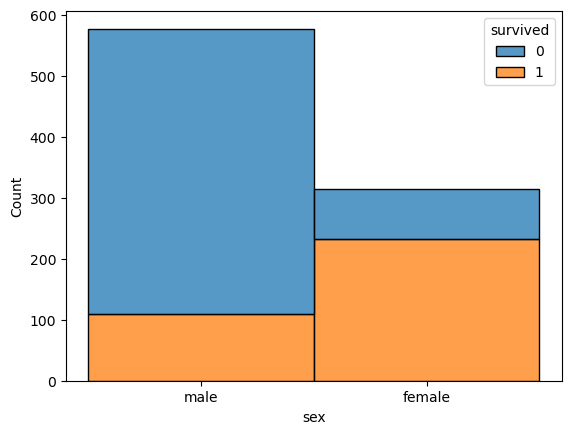

In [15]:
sns.histplot(train_df,
            x='sex',
            hue='survived',
            multiple='stack')

### 'age'

<b> Age is a continuous variable, but has some missing values.

</b>

<Axes: xlabel='age', ylabel='Count'>

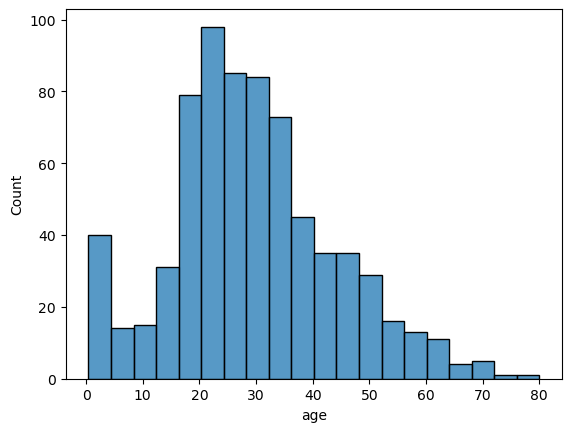

In [16]:
# histogram of 'age'
sns.histplot(train_df, x='age')

<b> Fill <i> age </i> with mean value.
    
<b>By filling age with the mean value we get a spike at the mean.

<b>Nothing special, do not include.
</b>

<Axes: xlabel='age_mean_filled', ylabel='Count'>

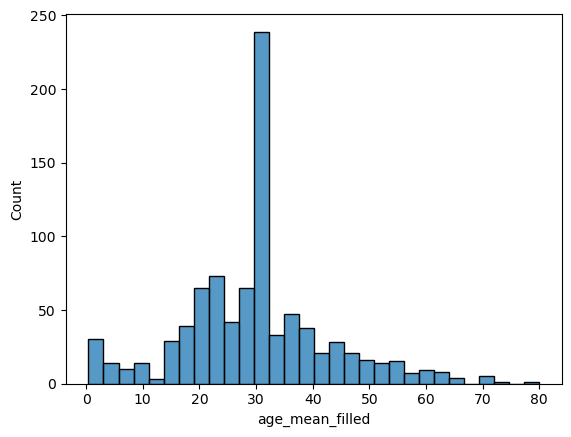

In [17]:
# make transformartion
train_df["age_mean_filled"]= train_df['age']
train_df['age_mean_filled'].fillna(train_df["age"].mean(), inplace=True)

# obtain histogram
sns.histplot(train_df,
            x='age_mean_filled')

<b> Fill <i> age </i> with values from the fitted normal distribution.

<b>Fit a normal distribution to the 'age' column, then draw a sample from that distribution and fill the missing values using the sample. The resulting histogram is more similar to the original data. 

<b>Looks promising, include.

</b>

<Axes: xlabel='age_norm_filled', ylabel='Count'>

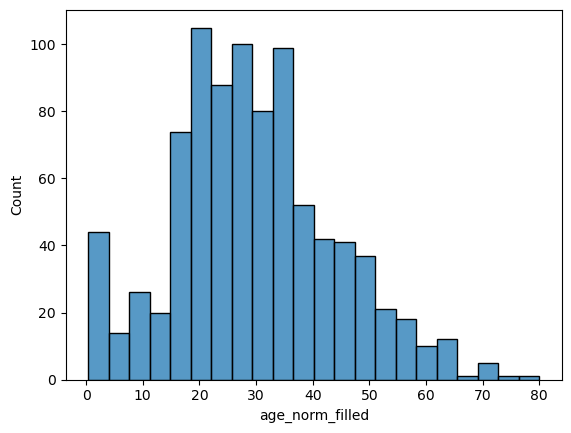

In [62]:
# create the feature column to be filled...
train_df['age_norm_filled'] = train_df['age']

# fit normal distribution to the training datas' age feature after removing missing values
age_nona = train_df[train_df['age'].isna() == False]['age']
fit_params = norm.fit(age_nona)
mean, std_dev = fit_params

# draw a random sample from the distribution
random_sample = norm.rvs(mean, std_dev, size=200, random_state=42)
# limit the sample values to be > 0
positive_random_sample = random_sample[random_sample > 0]

# obtain the indices of the missing values
missing_indices = train_df.index[train_df['age_norm_filled'].isnull()]

# fill the instances with the random sample
train_df.loc[missing_indices, 'age_norm_filled'] = positive_random_sample[:len(missing_indices)]

# obtain histogram
sns.histplot(train_df,
            x='age_norm_filled')

<b> 
Looking at the heatmap of the categorized and norm-filled 'age' we can see that the lowest survival rates are between 17-29 and that the highest survival rates are amongs those under 17. The groups above 30 have a similar survival rate.

Looks promising, should include as feature.
</b>

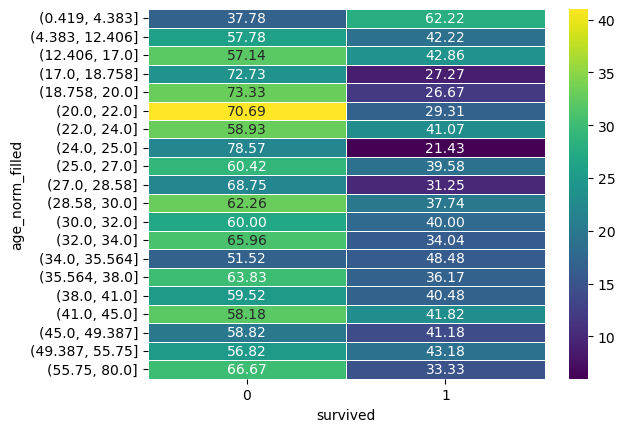

In [19]:
# categorize 'age_norm_filled'
age_norm_filled_binned = pd.qcut(train_df['age_norm_filled'], q=20)

# obtain contingency table of categorised 'fare' and 'survived'
age_filled_contingency_table = pd.crosstab(age_norm_filled_binned, train_df['survived'])

# obtain relative row percentages
row_totals = age_filled_contingency_table.sum(axis=1)
row_percentages = pd.DataFrame({'0': age_filled_contingency_table[0]/row_totals*100, 
                                '1': age_filled_contingency_table[1]/row_totals*100})

# obtain heatmap
sns.heatmap(age_filled_contingency_table, annot=row_percentages, cmap='viridis', fmt=".2f", linewidth=0.5)

train_df['age_norm_filled_binned'] = age_norm_filled_binned

<b> 
Square transform <i> age </i> fill from a fitted beta distribution.

Nothing special, do not include.
</b>

<Axes: xlabel='age_sqr_beta_filled', ylabel='Count'>

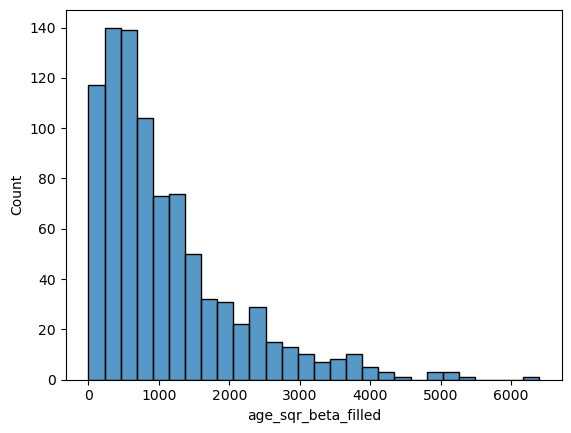

In [20]:
# create the feature column to be filled with sqr transformed age values (in order that it fits the beta dist more)
train_df['age_sqr_beta_filled'] = train_df['age']**2

# fit beta distribution to the training datas'
age_nona = train_df[train_df['age_sqr_beta_filled'].isna() == False]['age_sqr_beta_filled']
fit_params = beta.fit(age_nona)
a, b, c, d = fit_params

# draw a random sample from the distribution
random_sample = beta.rvs(a, b, loc=c, scale=d, size=177, random_state=42)

# obtain the indices of the missing values
missing_indices = train_df.index[train_df['age_sqr_beta_filled'].isnull()]

# fill the instances with the random sample
train_df.loc[missing_indices, 'age_sqr_beta_filled'] = random_sample

# obtain histogram
sns.histplot(train_df,
            x='age_sqr_beta_filled')

### 'pclass'

<b> The chi-squared test results in a very low p-value suggesting that there is a definite correlation between 'pclass' and 'survived'. 
    
<b> The heatmap of 'pclass' and 'survived' that show a pattern of decreasing relative-frequency of the survival rate as the passenger class goes up. The heatmaps for expected and observed frequencies are different.

<b> Looks promising, should be included.
</b>

In [21]:
# Obtain contingency table of 'pclass' and 'survived'
pclass_contingency_table = pd.crosstab(train_df['pclass'], train_df['survived'])

# claculate chi-squared test for 'pclass' and 'survived'
chi2, p, _, __ = chi2_contingency(pclass_contingency_table)
print(f"The test statistic is: {chi2}\nThe p-value is: {p}\nThe degrees of freedom is: {_}")

The test statistic is: 102.88898875696056
The p-value is: 4.549251711298793e-23
The degrees of freedom is: 2


<Axes: >

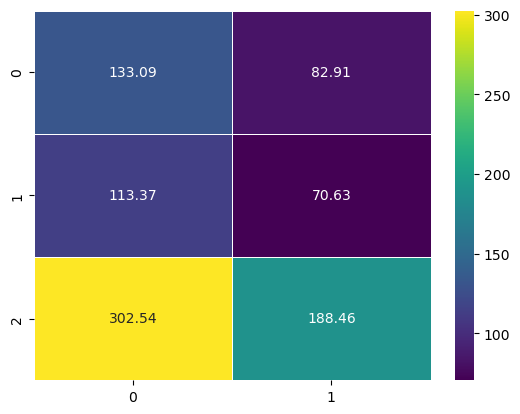

In [22]:
# obtain a heatmap of the expected values of 'pclass' and 'survived' from the chi-squared dist.
sns.heatmap(__, annot=True, cmap='viridis', fmt=".2f", linewidth=0.5)

<Axes: xlabel='survived', ylabel='pclass'>

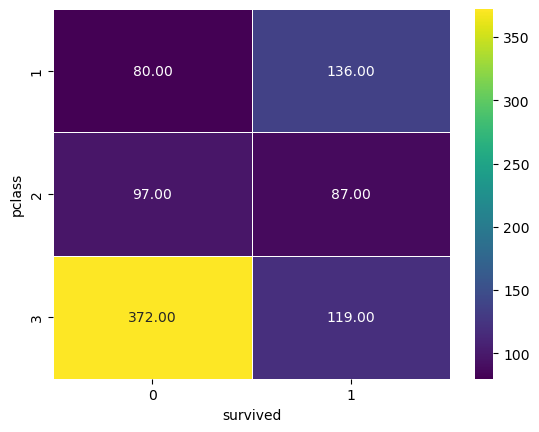

In [24]:
# obtain a heatmap of the observed frequencies of 'pclass' and 'survived'
sns.heatmap(pclass_contingency_table, annot=True, cmap='viridis', fmt=".2f", linewidth=0.5)

### 'fare'

<b> Looking at a histogram of 'fare', we can see an increase in relative survival rate as 'fare' goes up.

<b> After categorising 'fare' we can see the survival rate increasing as fare goes up. 

<b> Looks promising, both should be included.
</b>

<Axes: xlabel='fare', ylabel='Count'>

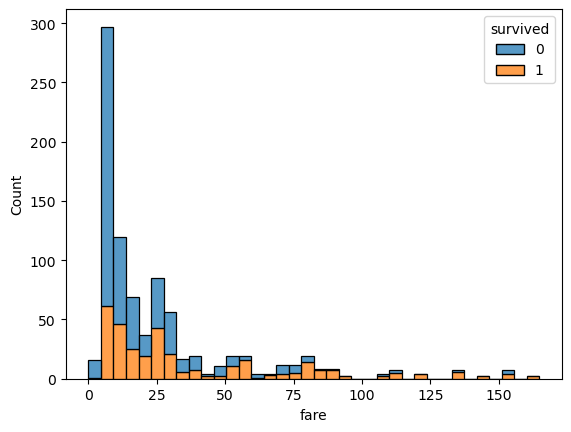

In [25]:
sns.histplot(train_df[train_df['fare'] < 200],
             x='fare',
            hue='survived',
            multiple='stack')

<Axes: xlabel='survived', ylabel='fare'>

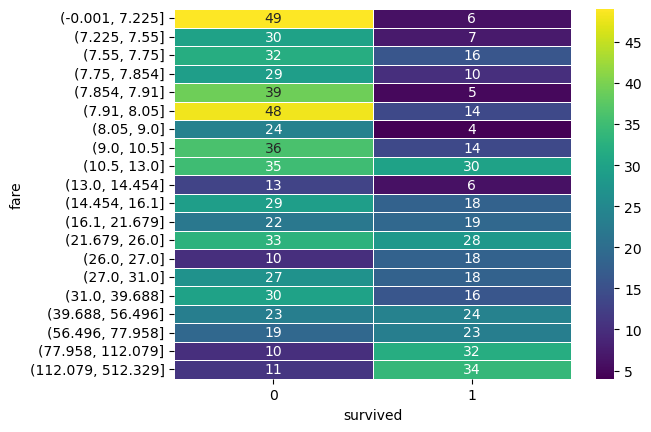

In [26]:
# categorise 'fare' into 3 bins
binned_fare = pd.qcut(train_df['fare'], q=20)

# obtain contingency table of categorised 'fare' and 'survived'
fare_contingency_table = pd.crosstab(binned_fare, train_df['survived'])

# # obtain relative row percentages
# row_totals = fare_contingency_table.sum(axis=1)
# row_percentages = pd.DataFrame({'0': fare_contingency_table[0]/row_totals*100, 
#                                 '1': fare_contingency_table[1]/row_totals*100})

# obtain heatmap
sns.heatmap(fare_contingency_table, annot=True, cmap='viridis', linewidth=0.5)

In [27]:
# add the binned 'fare' as a feature to the training data
train_df['binned_fare'] = binned_fare

### 'sibsp' & 'parch'

<b> 'sibsp' and 'parch' are very similar and difficult to comprehend.

<b>Create new feature <i>'alone'</i> that signifies whether someone was alone (sibsp and parch both are 0)

<b> Uncertain, both should be included
</b>

In [28]:
train_df['alone'] = (train_df['sibsp'] == 0) & (train_df['parch'] == 0)

### 'embarked'

<b> Missing some values, so fill in <i> embarked </i> with the most popular value 

<b> Unlikely to be predictive, but include at first.

</b>

In [29]:
train_df['embarked'].fillna(train_df['embarked'].mode()[0], inplace=True)

# Initial model training and evaluation

<b>Get training and test labels</b>

In [31]:
y_train = train_df['survived']
y_test = test_df['survived']

<b>Select features

</b>

In [32]:
features = ['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'binned_fare', 
            'age_norm_filled', 'age_norm_filled_binned', 'alone']
X_train = pd.get_dummies(train_df[features])

<b>Specify the models to be trained

<b>We select a range of classification algorithms and evaluate them using k-fold validation.

</b>

In [33]:
models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), SVC(), GaussianNB(),
         KNeighborsClassifier(), MLPClassifier(), AdaBoostClassifier()]
model_names = ["LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier", 
               "SVC", "GaussianNB","KNeighborsClassifier", "MLPClassifier", 
               "AdaBoostClassifier"]

<b> Train and evaluate the models using the function specified above.</b>

In [34]:
initial_models = train_models(models, model_names)
initial_models

,Accuracy,Mean Acc.,Std. Dev.,Fitting
RandomForestClassifier,0.988777,0.807004,0.041417,0.181773
AdaBoostClassifier,0.836139,0.800262,0.025163,0.035877
LogisticRegression,0.830527,0.793508,0.025057,0.037019
DecisionTreeClassifier,0.988777,0.774482,0.040755,0.214295
MLPClassifier,0.867565,0.771136,0.047902,0.096428
GaussianNB,0.750842,0.707191,0.041302,0.043651
KNeighborsClassifier,0.795735,0.699276,0.052703,0.096459
SVC,0.681257,0.676854,0.048456,0.004403


# Further Model training & evaluation - 2

<b> Optimize random forest classifier, the best performing method.</b>

In [35]:
# Sample parameter grid for Random Forest Classifier
param_grid = {
    'n_estimators': [100, 200, 300, 400],          # Number of trees in the forest
    'min_samples_split': [5, 10, 20],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest Classifier model
rf_classifier = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features='sqrt', random_state=42,
                                      min_samples_leaf=4, min_samples_split=10, n_estimators=200)

# Perform grid search
rf_grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
rf_classifier_optimized = rf_grid_search.best_estimator_


# Get the best parameters
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_
print(f"Best Parameters: {best_params}\nBest score: {best_score}")

Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best score: 0.8283284162952734


<b> Obtain a table of features in descending order of importance </b>

In [36]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importances': rf_classifier_optimized.feature_importances_})
feature_importance.sort_values('Importances', ascending=False)

,Feature,Importances
6,sex_female,0.213964
7,sex_male,0.197061
3,fare,0.115418
0,pclass,0.096311
4,age_norm_filled,0.077513
1,sibsp,0.032334
2,parch,0.022286
5,alone,0.016278
31,"age_norm_filled_binned_(0.419, 4.383]",0.014393
39,"age_norm_filled_binned_(25.0, 27.0]",0.014165


<b>Select features

<b>According to the table above, we arbitrarily select features with a score higher or around 0.1.

</b>

In [50]:
features = ['pclass', 'sex', 'fare', 'sibsp', 'parch', 'age_norm_filled']
X_train = pd.get_dummies(train_df[features])

<b> Optimize random forest classifier </b>

In [51]:
# Sample parameter grid for Random Forest Classifier
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees in the forest
    'min_samples_split': [5, 10, 20],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest Classifier model
rf_classifier = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features='sqrt', random_state=42,
                                      min_samples_leaf=4, min_samples_split=10, n_estimators=200)

# Perform grid search
rf_grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
rf_classifier_optimized = rf_grid_search.best_estimator_


# Get the best parameters
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_
print(f"Best Parameters: {best_params}\nBest score: {best_score}")

Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8328165212478815


<b> Obtain a table of features in descending order of importance.

<b> After playing around with the features a while, the best validation scores appear when 'sibsp' and 'parch' are included.

</b>

In [39]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importances': rf_classifier_optimized.feature_importances_})
feature_importance.sort_values('Importances', ascending=False)

,Feature,Importances
4,sex_male,0.238294
3,sex_female,0.217579
1,fare,0.208291
2,age_norm_filled,0.196726
0,pclass,0.139110


# Test

<b> We add the missing 'age_norm_filled' feature to the test data, by sampling the fitted normal distribution from earlier. We replace the missing values the same way.

<b> Note; we are using the distribution fitted to the test data.

</b>

In [65]:
# create the feature column to be filled...
test_df['age_norm_filled'] = test_df['age']
# draw a random sample from the distribution
random_sample = norm.rvs(mean, std_dev, size=150, random_state=42)
# limit the sample values to be > 0
positive_random_sample = random_sample[random_sample > 0]

# obtain the indices of the missing values
missing_indices = test_df.index[test_df['age_norm_filled'].isnull()]

# fill the instances with the random sample
test_df.loc[missing_indices, 'age_norm_filled'] = positive_random_sample[:len(missing_indices)]

<b>Fare is missing a value which we'll fill with the mean of 'fare' from the training data. </b>

In [68]:
test_df['fare'].fillna(train_df['fare'].mean(), inplace=True)

<b>Now the test data looks ready.</b>

In [69]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   survived         418 non-null    int64  
 1   pclass           418 non-null    int64  
 2   name             418 non-null    object 
 3   sex              418 non-null    object 
 4   age              332 non-null    float64
 5   sibsp            418 non-null    int64  
 6   parch            418 non-null    int64  
 7   fare             418 non-null    float64
 8   embarked         418 non-null    object 
 9   age_norm_filled  418 non-null    float64
dtypes: float64(3), int64(4), object(3)
memory usage: 32.8+ KB


<b>Obtain test data with selected features.
</b>

In [76]:
X_test = pd.get_dummies(test_df[features])

<b>Get predictions using our fitted model</b>

In [77]:
y_pred = rf_classifier_optimized.predict(X_test)

In [79]:
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy of the final model on the test data is: {accuracy:}")

The accuracy of the final model on the test data is: 0.7511961722488039


In [1]:
aaa

NameError: name 'aaa' is not defined